# 6-手机GPS/信令数据处理

本样例展示如何用TransBigData处理手机信令数据
首先导入包并读取数据。所使用的样例数据可在这里下载：[浙江手机数据](https://github.com/yang9599/travel_intention_prediction/tree/master/data)

In [1]:
import pandas as pd
import transbigdata as tbd

data = pd.read_csv(r'data/mobiledata_sample.csv')
#确保时间列准确识别（很重要）
data['stime'] = pd.to_datetime(data['stime'], format='%Y%m%d%H%M')
data = data.sort_values(by = ['user_id','stime'])
data.head()

,user_id,stime,longitude,latitude,date
78668,00466ab30de56db7efbd04991b680ae1,2018-06-01 00:00:00,121.43,30.175,20180601
78669,00466ab30de56db7efbd04991b680ae1,2018-06-01 03:35:00,121.43,30.175,20180601
78670,00466ab30de56db7efbd04991b680ae1,2018-06-01 04:25:00,121.43,30.175,20180601
78671,00466ab30de56db7efbd04991b680ae1,2018-06-01 05:15:00,121.43,30.175,20180601
78289,00466ab30de56db7efbd04991b680ae1,2018-06-01 06:05:00,121.43,30.175,20180601


## 识别出行和停留

处理手机数据时，TransBigData的方法是先将数据对应至栅格，将同一个栅格内的数据视为在同一个位置，以避免数据定位误差导致同一位置被识别为多个。

In [2]:
#获取栅格参数
params = tbd.area_to_params([121.860, 29.295, 121.862, 29.301], accuracy=500)
#从手机数据中识别出行和停留
stay,move = tbd.mobile_stay_move(data,params,col = ['user_id','stime','longitude', 'latitude'])

In [3]:
#停留
stay.head()

,user_id,stime,LONCOL,LATCOL,etime,lon,lat,duration
0,00466ab30de56db7efbd04991b680ae1,2018-06-01 00:00:00,-83,196,2018-06-01 07:21:00,121.432040,30.176335,26460.0
1,00466ab30de56db7efbd04991b680ae1,2018-06-01 07:36:00,-81,191,2018-06-01 12:02:00,121.442352,30.153852,15960.0
2,00466ab30de56db7efbd04991b680ae1,2018-06-01 12:20:00,-83,196,2018-06-01 13:04:00,121.432040,30.176335,2640.0
3,00466ab30de56db7efbd04991b680ae1,2018-06-01 14:34:00,-60,189,2018-06-01 23:12:00,121.550631,30.144858,31080.0
4,00466ab30de56db7efbd04991b680ae1,2018-06-02 00:02:00,-83,196,2018-06-02 09:36:00,121.432040,30.176335,34440.0


In [4]:
#出行
move.head()

,user_id,SLONCOL,SLATCOL,stime,slon,slat,etime,elon,elat,ELONCOL,ELATCOL,duration
0,00466ab30de56db7efbd04991b680ae1,-83,196,2018-06-01 07:21:00,121.432040,30.176335,2018-06-01 07:36:00,121.442352,30.153852,-81.0,191.0,900.0
1,00466ab30de56db7efbd04991b680ae1,-81,191,2018-06-01 12:02:00,121.442352,30.153852,2018-06-01 12:20:00,121.432040,30.176335,-83.0,196.0,1080.0
2,00466ab30de56db7efbd04991b680ae1,-83,196,2018-06-01 13:04:00,121.432040,30.176335,2018-06-01 14:34:00,121.550631,30.144858,-60.0,189.0,5400.0
3,00466ab30de56db7efbd04991b680ae1,-60,189,2018-06-01 23:12:00,121.550631,30.144858,2018-06-02 00:02:00,121.432040,30.176335,-83.0,196.0,3000.0
4,00466ab30de56db7efbd04991b680ae1,-83,196,2018-06-02 09:36:00,121.432040,30.176335,2018-06-02 10:56:00,121.406259,30.176335,-88.0,196.0,4800.0


## 识别居住地与工作地

- 居住地识别规则为夜晚时段停留最长地点
- 工作地识别规则为工作日白天时段停留最长地点（每日平均时长大于`minhour`）。

In [5]:
#识别居住地
home = tbd.mobile_identify_home(stay, col=['user_id','stime', 'etime','LONCOL', 'LATCOL','lon','lat'], start_hour=8, end_hour=20 )
home.head()

,user_id,LONCOL,LATCOL,lon,lat
1781,fcc3a9e9df361667e00ee5c16cb08922,-147,292,121.102046,30.608009
1769,f71e9d7d78e6f5bc9539d141e3a5a1c4,-216,330,120.746272,30.778880
1752,f6b65495b63574c2eb73c7e63ae38252,-225,-286,120.699867,28.008971
1739,f1f4224a60da630a0b83b3a231022123,102,157,122.385927,30.000967
1700,e96739aedb70a8e5c4efe4c488934b43,-223,278,120.710179,30.545056


In [6]:
#识别工作地
work = tbd.mobile_identify_work(stay, col=['user_id', 'stime', 'etime', 'LONCOL', 'LATCOL','lon','lat'], minhour=3, start_hour=8, end_hour=20,workdaystart=0, workdayend=4)
work.head()

,user_id,LONCOL,LATCOL,lon,lat
0,fcc3a9e9df361667e00ee5c16cb08922,-146,292,121.107203,30.608009
1,f71e9d7d78e6f5bc9539d141e3a5a1c4,-219,325,120.730804,30.756397
2,f6b65495b63574c2eb73c7e63ae38252,-225,-286,120.699867,28.008971
3,f1f4224a60da630a0b83b3a231022123,103,153,122.391083,29.982981
5,e1a1dfb5a77578c889bd3368ffe1d30f,-62,138,121.540319,29.915532


In [7]:
# 如果要确保工作地与居住地不同
home['flag'] = 1
work = pd.merge(work,home,how='left')
home = home.drop(['flag'],axis = 1)
work = work[work['flag'].isnull()].drop(['flag'],axis = 1)

## 绘制活动图

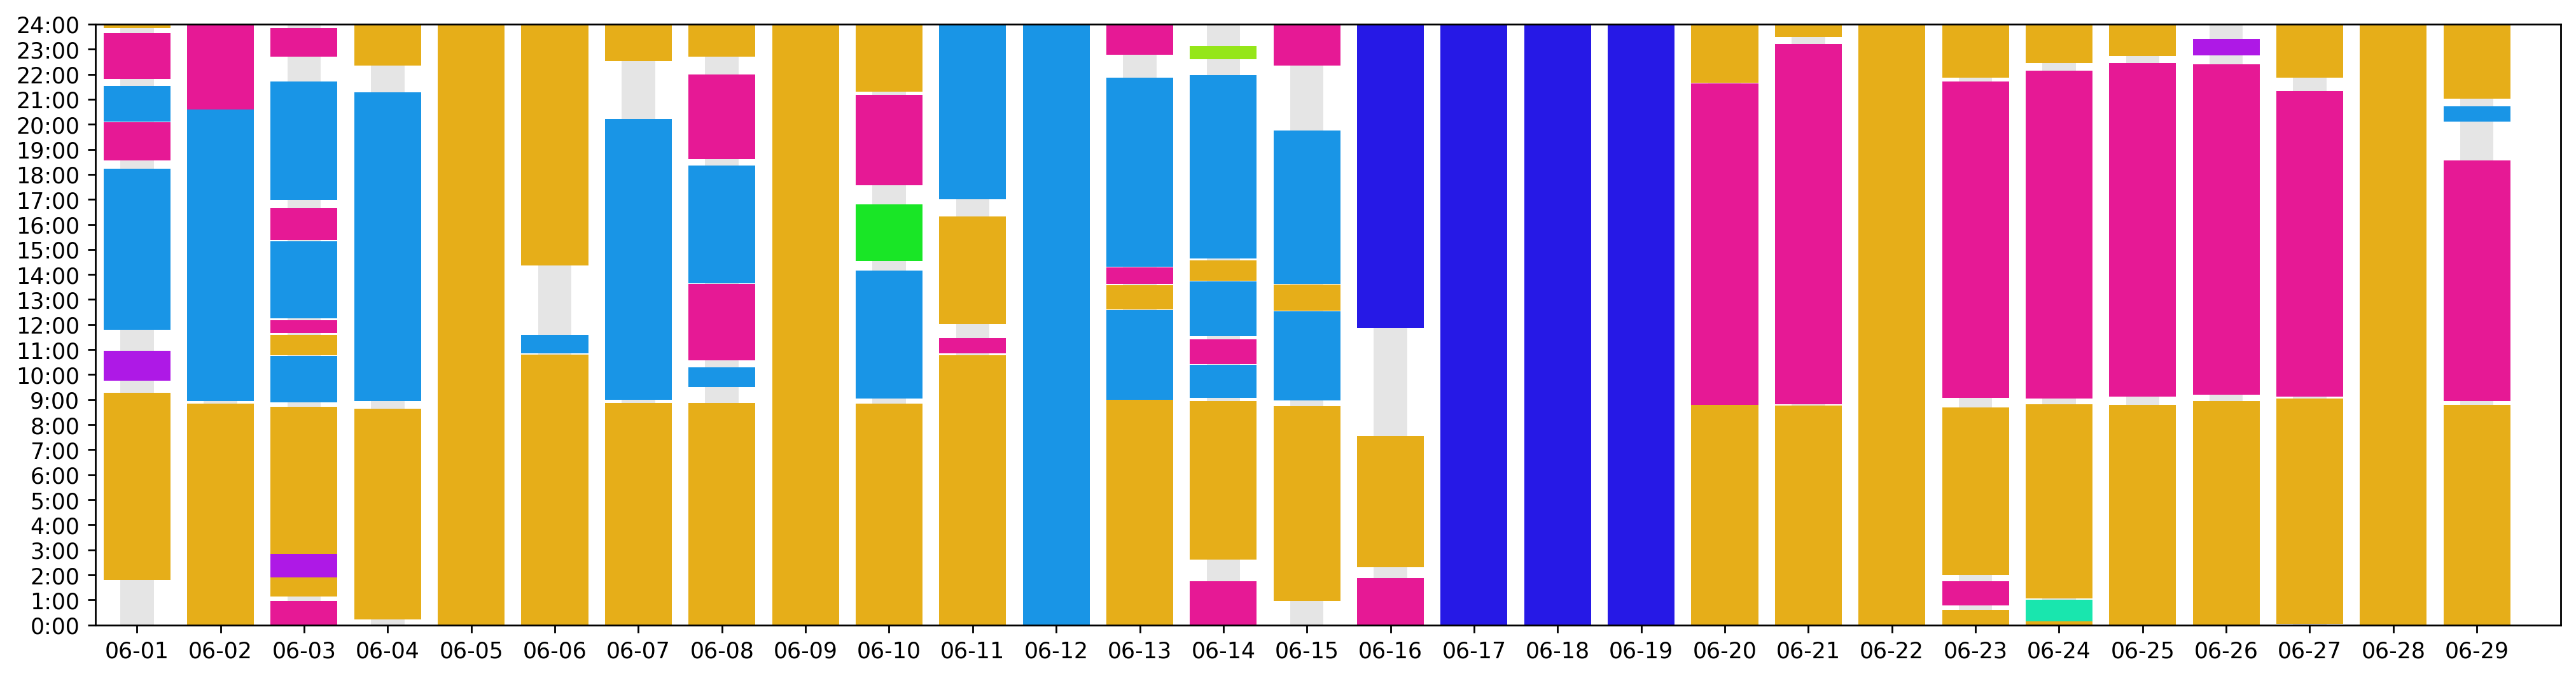

In [8]:
#绘制某一用户的活动图，不同颜色代表不同活动
uid = 'fcc3a9e9df361667e00ee5c16cb08922'
tbd.mobile_plot_activity(stay[stay['user_id']==uid],figsize = (20, 5))